This is an Experimental release. Experiments are focused on validating a prototype. They are not guaranteed to be released and might be subject to backward-incompatible changes. They are not intended for production use or covered by any SLA,  support obligation, or deprecation policy. They are covered by the [Pre-GA Offerings Terms](https://cloud.google.com/terms/service-terms#1) of the Google Cloud Platform Terms of Services.



Note that this only feature is **only available in [Unified Cloud AI Platform](https://cloud.google.com/ai-platform-unified/docs/start/introduction-unified-platform)**, it is not supported in legacy AI Platform.

Please fill out this [form](https://docs.google.com/forms/d/1tniFkxb2BDtpPEatV3hXczPLPqofgpCJCvGZDpQlPFg/edit) to get allowlisted.

Google internal users please subscribe  [ai-platform-unified-model-monitoring-trusted-tester@googlegroups.com](https://groups.google.com/g/ai-platform-unified-model-monitoring-trusted-tester) for updates (All external customers will be added to this group after filling out above form).

If you have any questions or feedback, please send it to gcp-model-monitor-feedback@google.com

# Tutorial: Model Monitoring in Unified AI Platform (Preview)
This tutorial describes the steps to create a model deployment monitoring job for your Endpoint on the next generation of Google’s Cloud AI Platform.

The code in this tutorial is tested in Notebook.

## Before you begin

### Download and install libraries

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

!pip install tensorflow==2.4.1

import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

import tensorflow as tf

print('Installing TensorFlow Data Validation')
!pip install -q tensorflow_data_validation[visualization]

!pip install --upgrade google-cloud-storage google-api-python-client google-auth-oauthlib google-auth-httplib2 oauth2client requests

     |████████████████████████████████| 3.8 MB 4.8 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.37.0
    Uninstalling grpcio-1.37.0:
      Successfully uninstalled grpcio-1.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx 0.28.0 requires docker<5,>=4.1, but you have docker 5.0.0 which is incompatible.
tfx 0.28.0 requires kubernetes<12,>=10.0.1, but you have kubernetes 12.0.1 which is incompatible.
tfx 0.28.0 requires pyarrow<3,>=1, but you have pyarrow 3.0.0 which is incompatible.
tensorflow-transform 0.28.0 requires pyarrow<3,>=1, but you have pyarrow 3.0.0 which is incompatible.
tensorflow-model-analysis 0.28.0 requires pyarrow<3,>=1, but you have pyarrow 3.0.0 which is incompatible.
tensorflow-data-validation 0.28.0 requires joblib<0.15,>=0.12, but you have joblib 1.0.1 which is incompatible.
tensorflow-da

### [Colab user only] Restart your colab runtime and authenticate
If you are using Google Colab, the first time that you run the cell above, you must restart the runtime (Runtime > Restart runtime ...). This is because of the way that Colab loads packages.

In [ ]:
! gcloud auth login

### API client lib preparation

In [ ]:
PYTHON_CLIENT_LIBRARY = 'gs://model_monitoring_python_client_library/aiplatform-v1alpha1-py-02-28.tar.gz'
LOCAL_PYTHON_CLIENT_LIBRARY = './content/python_client_library/aiplatform-v1alpha1-py.tar.gz'
! gsutil cp $PYTHON_CLIENT_LIBRARY $LOCAL_PYTHON_CLIENT_LIBRARY
! pip3 install $LOCAL_PYTHON_CLIENT_LIBRARY

In [ ]:
PROJECT_ID = "" #@param {type:"string"}

In [ ]:
! gcloud config set project $PROJECT_ID

### [Colab user only] Restart your colab runtime and authenticate
If you are using Google Colab, the first time that you run the cell above, you must restart the runtime (Runtime > Restart runtime ...). This is because of the way that Colab loads packages. After restart runtime, please authenticate.

In [ ]:
! gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=ccxDTuNV7IlSbLCdNP9MjHIsufqEZK&prompt=consent&access_type=offline&code_challenge=DKC7ZE_yYDxWEnry0s8N4Z2nO3Sk0fZx4rA3LpA1eIw&code_challenge_method=S256

Enter verification code: 

In [ ]:
LOCATION = 'us-central1'
API_ENDPOINT = 'us-central1-aiplatform.googleapis.com'
PREDICT_API_ENDPOINT = 'us-central1-prediction-aiplatform.googleapis.com'

## Set configuration and Create common libraries

In [ ]:
USER_EMAIL = "" #@param {type:"string"}
JOB_DISPLAY_NAME = "test-job" #@param {type:"string"}
ENDPOINT_RESOURCE_ID = "" #@param {type:"string"}

# We will log your prediction request and response to BigQuery tables.
# Please config the logging sampling rate.
LOG_SAMPLE_RATE =  0.8#@param {type:"number"}
# The Monitoring Interval in seconds, 
# for how often we should analyze your data and report anomalies.
MONITOR_INTERVAL_IN_SECONDS =  3600#@param {type:"number"}

In [ ]:
# Commonly used create job function.
from google.protobuf.struct_pb2 import Value
from google.protobuf.duration_pb2 import Duration
from google.cloud.aiplatform_v1alpha1.services.job_service import JobServiceClient
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import ThresholdConfig
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import SamplingStrategy
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import ModelMonitoringAlertConfig
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import ModelMonitoringObjectiveConfig
from google.cloud.aiplatform_v1alpha1.types.model_deployment_monitoring_job import ModelDeploymentMonitoringJob
from google.cloud.aiplatform_v1alpha1.types.model_deployment_monitoring_job import ModelDeploymentMonitoringObjectiveConfig
from google.cloud.aiplatform_v1alpha1.types.model_deployment_monitoring_job import ModelDeploymentMonitoringScheduleConfig
import os

def create_model_deployment_monitoring_job(monitoring_objective_configs):
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  parent = "projects/{project}/locations/{location}".format(
      project=PROJECT_ID, location=LOCATION
  )

  model_deployment_monitoring_job = ModelDeploymentMonitoringJob(
      display_name = JOB_DISPLAY_NAME,
      endpoint = 'projects/{}/locations/us-central1/endpoints/{}'.format(PROJECT_ID, ENDPOINT_RESOURCE_ID),
      # ModelDeploymentMonitoringObjectiveConfig.
      model_deployment_monitoring_objective_configs = monitoring_objective_configs,
      # LoggingSamplingStrategy for Serving data.
      logging_sampling_strategy = SamplingStrategy(
          random_sample_config = SamplingStrategy.RandomSampleConfig(
              sample_rate = LOG_SAMPLE_RATE
          )
      ),
      # ModelDeploymentMonitoringScheduleConfig
      model_deployment_monitoring_schedule_config = ModelDeploymentMonitoringScheduleConfig(
          monitor_interval = Duration(
              seconds = MONITOR_INTERVAL_IN_SECONDS
          )
      ),
      # ModelMonitoringAlertConfig
      model_monitoring_alert_config = ModelMonitoringAlertConfig(
          email_alert_config = ModelMonitoringAlertConfig.EmailAlertConfig(
              user_emails = [USER_EMAIL]
          )
      ),
      predict_instance_schema_uri = '',
      analysis_instance_schema_uri = ''
  )

  response = client.create_model_deployment_monitoring_job(
      parent=parent, model_deployment_monitoring_job=model_deployment_monitoring_job
  )
  print('Created ModelDeploymentMonitoring Job:')
  print(response)
  return response

# Define util function to parse threshold strings
DEFAULT_THRESHOLD_VALUE = 0.001

def get_thresholds(default_threshold_str, customized_threshold_str):
  # Features require drift detection.
  thresholds_dict = {}

  default_threshold = ThresholdConfig(value = DEFAULT_THRESHOLD_VALUE)
  # Default values.
  for feature_name in default_threshold_str.split(','):
    feature_name = feature_name.strip()
    thresholds_dict[feature_name] = default_threshold
  # Custom values.
  for feature_threshold_pair in customized_threshold_str.split(','):
    split_pair = feature_threshold_pair.split(':')
    if len(split_pair) != 2:
      print('Invalid custom skew threshold: ' + feature_threshold_pair)
      return
    feature_name = split_pair[0].strip()
    threshold_value = float(split_pair[1])
    threshold = ThresholdConfig(value = threshold_value)
    thresholds_dict[feature_name] = threshold
  
  return thresholds_dict

# Define util for listing all deployed models.
from google.cloud.aiplatform_v1alpha1.services.endpoint_service import EndpointServiceClient

def get_deployed_model_ids():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = EndpointServiceClient(client_options=client_options)

  parent = "projects/{project}/locations/{location}".format(
      project=PROJECT_ID, location=LOCATION
  )
  response = client.get_endpoint(
      name="projects/{}/locations/us-central1/endpoints/{}".format(PROJECT_ID, ENDPOINT_RESOURCE_ID)
  )

  deployed_model_ids = []
  for deployed_model in response.deployed_models:
    deployed_model_ids.append(deployed_model.id)
  return deployed_model_ids

The model monitoring API is to monitor each deployed model's skew/drift. Here for simplicity, we apply the same monitoring config for all models. Below is a util function to return a list of monitoring configs given a config template.

In [ ]:
import copy

deployed_model_ids = get_deployed_model_ids()
print('Here are the deployed model ids:\n {}'.format(deployed_model_ids))

def copy_monitoring_objective_for_each_model(monitoring_objective_template):
  # Use the same objective config for all models.
  monitoring_objective_configs = []
  for deployed_model_id in deployed_model_ids:
    monitoring_objective_config = copy.deepcopy(monitoring_objective_template)
    monitoring_objective_config.deployed_model_id = deployed_model_id
    monitoring_objective_configs.append(monitoring_objective_config)
  
  return monitoring_objective_configs

## Creation Model Monitoring Job


You need to specify the data drift threshold for the features you want to monitoring. The whole idea behind the alerting is to see if a feature's data distribution distance is above the threshold you set. If it is, we will send email alerts to the $USER_EMAIL you specified above.

How do we calculate the feature distribution distance? We use [L-infinity distance](https://en.wikipedia.org/wiki/Chebyshev_distance) for categorical features and [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) for numerical features. More details are [here](https://www.tensorflow.org/tfx/guide/tfdv#drift_detection).

Below you just need to specify the features that you want use default threshold(0.001) and the customized threshold features. If you don't want to monitor a feature, feel free to skip filling into any of these fields.


In [ ]:
FEATURES_ENABLE_DRIFT_DETECTION_WITH_DEFAULT_THRESHOLD = "age,cigsPerDay" #@param {type:"string"}
# If a feature appear in both FEATURES_ENABLE_DRIFT_DETECTION_WITH_DEFAULT_THRESHOLD
# and FEATURES_ENABLE_DRIFT_DETECTION_WITH_CUSTOM_THRESHOLD, we rely on the custom value.
FEATURES_ENABLE_DRIFT_DETECTION_WITH_CUSTOM_THRESHOLD = "totChol:0.2,sysBP:0.2" #@param {type:"string"}

Starts the job with prediction drift as the only monitoring objective

Note: if you want to enable the feature attributions score
(based on Sampled Sharpley method, more details are [here](https://cloud.google.com/ai-platform-unified/docs/explainable-ai)) monitoring, just change the "enable_feature_attributes" to True in monitoring_objective_config_template. Make sure your model is configed with explanations [requirement](https://cloud.google.com/ai-platform-unified/docs/explainable-ai/configuring-explanations). 

In [ ]:
drift_detection_thresholds = get_thresholds(
    FEATURES_ENABLE_DRIFT_DETECTION_WITH_DEFAULT_THRESHOLD,
    FEATURES_ENABLE_DRIFT_DETECTION_WITH_CUSTOM_THRESHOLD)

monitoring_objective_config_template = ModelDeploymentMonitoringObjectiveConfig(
    objective_config = ModelMonitoringObjectiveConfig(
        prediction_drift_detection_config = ModelMonitoringObjectiveConfig.PredictionDriftDetectionConfig(
            drift_thresholds = drift_detection_thresholds
        ),
        explanation_config = ModelMonitoringObjectiveConfig.ExplanationConfig(
            enable_feature_attributes = False
        )
    )  
)

monitoring_objective_configs = copy_monitoring_objective_for_each_model(
    monitoring_objective_config_template)

monitoring_job = create_model_deployment_monitoring_job(
    monitoring_objective_configs)


## Prepare fake prediction traffic for testing
In this section, we will help you generate some fake data to send to your Endpoint for prediction. This will generate some logs for us to analyze the feature distributions.

Note: The instance needs to follow a key-value pairs format, key is name of the feature and value is the feature value.


In [ ]:
ENDPOINT = 'projects/{}/locations/us-central1/endpoints/{}'.format(PROJECT_ID, ENDPOINT_RESOURCE_ID)
MONITORING_JOB = monitoring_job.name
print("Endpoint: " + ENDPOINT)
print("Monitoring Job: " + MONITORING_JOB)

In [ ]:
from google.cloud.aiplatform_v1alpha1.services.prediction_service import PredictionServiceClient
from google.cloud.aiplatform_v1alpha1.types.prediction_service import PredictRequest
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

import time
def send_predict_request(totChol):
  client_options = {
      "api_endpoint": PREDICT_API_ENDPOINT
  }
  client = PredictionServiceClient(client_options=client_options)
  instance_dict = {
      "age": "30",
      "education": "4", 
      "currentSmoker": "0", 
      "cigsPerDay": "0", 
      "BPMeds": "0", 
      "prevalentStroke": "0", 
      "prevalentHyp": "0", 
      "diabetes": "0", 
      "totChol": totChol,
      "sysBP": "106", 
      "diaBP": "70", 
      "BMI": "18", 
      "heartRate": "1", 
      "glucose": "5", 
      "TenYearCHD": "0"
  }
  instance = json_format.ParseDict(instance_dict, Value())
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, Value())
  instances = [instance]
  request = PredictRequest(
      endpoint=ENDPOINT,
      parameters=parameters
  )
  request.instances.extend(instances)
  response = client.predict(request)

# Keep sending the request every one minute. It will last for 2 hours. You can 
# cancel it by interrupting the cell.
for i in range(0, 60):
  try:
    send_predict_request(str(i+100))
  except:
    print('predict request failed')
  time.sleep(60)

for i in range(0, 60):
  try:
    send_predict_request("100")
  except:
    print('predict request failed')
  time.sleep(60)

In between the 2 hour fake traffic running, you should be able to receive an email like this:
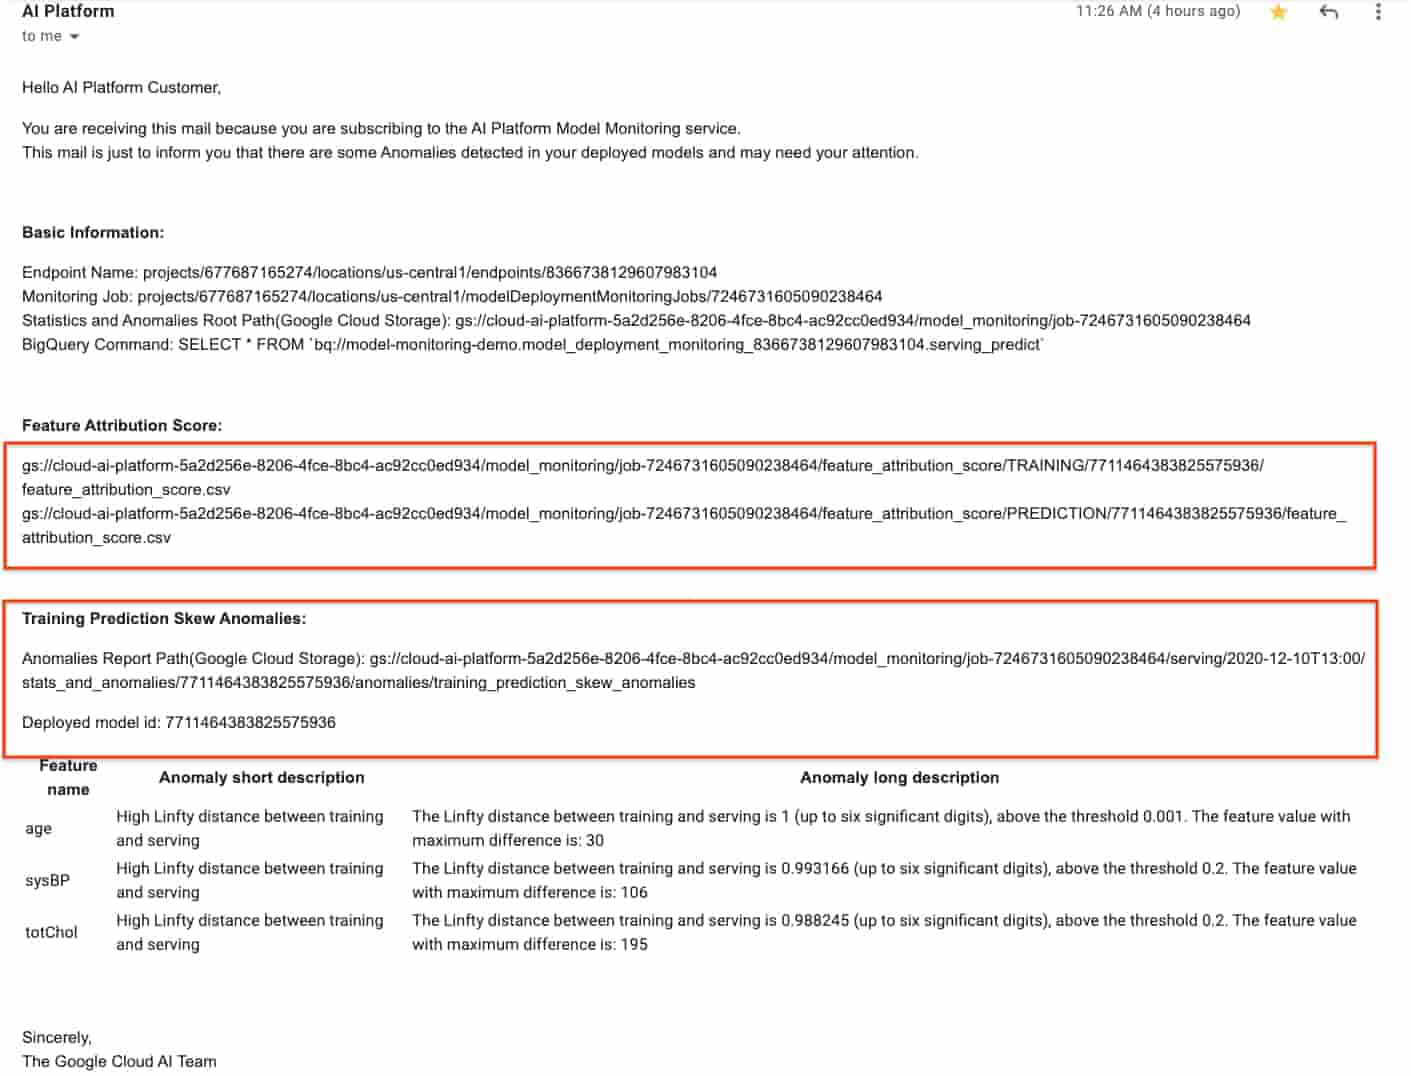
This email has the following key information:


1.   Basic information including endpoint resource name, monitoring job resource name and statistics/anomalies file path. We will try to visualize the stats using TFDV to diagnose.
2.   The feature attribution score csv path(if you have enabled the feature attribution monitoring). The first red box above shows both the training/prediction data feature attribution csv file paths. This will be used in the following visualization.
2.   The exact anomalies information, indicating whether this is training-serving skew or prediction drift. There are also the detailed anomaly information shown in the email.



## More API samples

### Update the monitoring config
You can try to update the model monitoring configs with our update API. For example if I want to update the email alerting config to include more engineers:

In [ ]:
UPDATED_USER_EMAIL_1 = "a@gmail.com" #@param {type:"string"}
UPDATED_USER_EMAIL_2 = "b@gmail.com" #@param {type:"string"}

In [ ]:
from google.cloud.aiplatform_v1alpha1.services.job_service import JobServiceClient
from google.cloud.aiplatform_v1alpha1.types.model_deployment_monitoring_job import ModelDeploymentMonitoringJob
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import ModelMonitoringAlertConfig
from google.protobuf.field_mask_pb2 import FieldMask

def update_model_deployment_monitoring_job():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  model_deployment_monitoring_job = ModelDeploymentMonitoringJob(
      name = MONITORING_JOB,
      model_monitoring_alert_config = ModelMonitoringAlertConfig(
          email_alert_config = ModelMonitoringAlertConfig.EmailAlertConfig(
              user_emails = [
              UPDATED_USER_EMAIL_1, # This can be any email domains
              UPDATED_USER_EMAIL_2,
            ]
          )
      )
  )

  update_mask = FieldMask(paths = ["model_monitoring_alert_config"])
  
  response = client.update_model_deployment_monitoring_job(
      model_deployment_monitoring_job=model_deployment_monitoring_job, update_mask=update_mask
  )
  print(response)

update_model_deployment_monitoring_job()

Or updating the alerting threshold by setting a higher skew threshold for age feature and adding the education for monitoring with a low threshold:


In [ ]:
from google.cloud.aiplatform_v1alpha1.services.job_service import JobServiceClient
from google.cloud.aiplatform_v1alpha1.types.model_deployment_monitoring_job import ModelDeploymentMonitoringJob
from google.cloud.aiplatform_v1alpha1.types.model_deployment_monitoring_job import ModelDeploymentMonitoringObjectiveConfig
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import ThresholdConfig
from google.cloud.aiplatform_v1alpha1.types.model_monitoring import ModelMonitoringObjectiveConfig
from google.protobuf.field_mask_pb2 import FieldMask

def update_model_deployment_monitoring_job():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  threshold = ThresholdConfig(value = 1e-05)
  
  monitoring_objective_config_template = ModelDeploymentMonitoringObjectiveConfig(
      objective_config = ModelMonitoringObjectiveConfig(
        training_dataset = ModelMonitoringObjectiveConfig.TrainingDataset(
          dataset = "projects/677687165274/locations/us-central1/datasets/2508579759236055040",
          target_field = "male"   
        ),
        training_prediction_skew_detection_config = ModelMonitoringObjectiveConfig.TrainingPredictionSkewDetectionConfig(
          skew_thresholds = {
            "age": threshold,
            "education": threshold
          }
        ),
        prediction_drift_detection_config = ModelMonitoringObjectiveConfig.PredictionDriftDetectionConfig(
          drift_thresholds = {
            "age": threshold
          }
        )
      )
  )
  monitoring_objective_configs = copy_monitoring_objective_for_each_model(
      monitoring_objective_config_template)
  model_deployment_monitoring_job = ModelDeploymentMonitoringJob(
      name = MONITORING_JOB,
      model_deployment_monitoring_objective_configs = monitoring_objective_configs
  )

  update_mask = FieldMask(paths = ["model_deployment_monitoring_objective_configs"])
  response = client.update_model_deployment_monitoring_job(
      model_deployment_monitoring_job=model_deployment_monitoring_job, update_mask=update_mask
  )
  print(response)

update_model_deployment_monitoring_job()

### Pause a monitoring job
If you do not want to monitor the endpoint and get alert, you can call pause API to pause the job.

Note: 
1. if there is a scheduled analysis being running, you may still get email notification for this analysis as pause function will not interrupt the running schedule. After the schedule is finished, there will not be any more analysis schedule.
2. Even after the job is paused, logging continuous in prediction service.

In [ ]:
def pause_model_deployment_monitoring_job():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  response = client.pause_model_deployment_monitoring_job(name=MONITORING_JOB)
  print(response)

pause_model_deployment_monitoring_job()

### Delete a paused job

In [ ]:
def delete_model_deployment_monitoring_job():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  response = client.delete_model_deployment_monitoring_job(name=MONITORING_JOB)
  print(response)

delete_model_deployment_monitoring_job()

### Resume a paused job

In [ ]:
def resume_model_deployment_monitoring_job():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  response = client.resume_model_deployment_monitoring_job(name=MONITORING_JOB)
  print(response)

resume_model_deployment_monitoring_job()

### Get a monitoring job

In [ ]:
def get_model_deployment_monitoring_job():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  client = JobServiceClient(client_options=client_options)
  response = client.get_model_deployment_monitoring_job(name=MONITORING_JOB)
  print(response)

get_model_deployment_monitoring_job()

### List monitoring jobs

In [ ]:
def list_model_deployment_monitoring_jobs():
  client_options = dict(
      api_endpoint = API_ENDPOINT
  )
  parent = 'projects/{}/locations/us-central1'.format(PROJECT_ID)
  client = JobServiceClient(client_options=client_options)
  response = client.list_model_deployment_monitoring_jobs(parent=parent)
  print(response)

list_model_deployment_monitoring_jobs()

# Clean up
The following steps are for clean up:
1. If the job is in running state, pause the job
2. Wait until the 'scheduleState' to be 'OFFLINE' and then delete the monitoring job
3. Delete the bigquery table.